In [1]:
# import the necessary packages
from imutils.contours import sort_contours
import numpy as np
import imutils
import cv2
from tensorflow import keras
import os
from matplotlib import pyplot as plt
from scipy import signal
from PIL import Image
plt.rcParams['figure.figsize'] = (20, 10)

In [76]:
def get_ocr_locs(scan_img):
    #serial no
    x, y, h, w = 1120, 140, 45, 180
    serial = scan_img[y:y+h, x:x+w]
    #plt.imshow(serial)

    plt.figure()
    #sheet no
    x, y, h, w = 1625, 140, 45, 180
    sheet = scan_img[y:y+h, x:x+w]
    #plt.imshow(sheet)
    return serial, sheet

input_path = "C:\\GitHub\\mf724-ocr\\ETL Documents\\"
image = "0.jpg"
image_path = input_path + image
scan_img = cv2.imread(image_path)
scan_img = imutils.resize(scan_img, height=1080, width=1920)
get_ocr_locs(scan_img)
print("a")

a


<Figure size 1440x720 with 0 Axes>

In [69]:
def denoise(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = np.asarray(image)/255.0
    # estimate 'background' color by a median filter
    bg = signal.medfilt2d(image, 11)
    # compute 'foreground' mask as anything that is significantly darker than
    # the background
    mask = image < bg - 0.1
    # return the input value for all pixels in the mask or pure white otherwise
    mask = np.where(mask, image, 1.0)
    tmp = np.asarray(mask*255.0, dtype=np.uint8)
    return tmp

In [84]:
def get_contours(image):
    # load the input image from disk, convert it to grayscale, and blur
    # it to reduce noise
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #_, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
   # blurred = cv2.GaussianBlur(thresh, (5, 5), 0)
    # perform edge detection, find contours in the edge map, and sort the
    # resulting contours from left-to-right
    edged = cv2.Canny(image, 50, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # initialize the list of contour bounding boxes and associated
    # characters that we'll be OCR'ing
    chars = []
    # loop over the contours
    for c in cnts:
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        # filter out bounding boxes, ensuring they are neither too small
        # nor too large
        if (w >= 5 and w <= 55) and (h >= 15 and h <= 80):
            # extract the character and threshold it to make the character
            # appear as *white* (foreground) on a *black* background, then
            # grab the width and height of the thresholded image
            roi = image[y:y + h, x:x + w]
            #print("get contours roi shape", roi.shape)
            thresh = cv2.threshold(roi, 0, 255,
                cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (tH, tW) = thresh.shape
            # if the width is greater than the height, resize along the
            # width dimension
            if tW > tH:
                thresh = imutils.resize(thresh, width=32)
            # otherwise, resize along the height
            else:
                thresh = imutils.resize(thresh, height=32)
            # re-grab the image dimensions (now that its been resized)
            # and then determine how much we need to pad the width and
            # height such that our image will be 32x32
            (tH, tW) = thresh.shape
            dX = int(max(0, 32 - tW) / 2.0)
            dY = int(max(0, 32 - tH) / 2.0)
            # pad the image and force 32x32 dimensions
            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
                left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            # prepare the padded image for classification via our
            # handwriting OCR model
            padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)
            # update our list of characters that will be OCR'd
            chars.append((padded, (x, y, w, h)))
            # extract the bounding box locations and padded characters
    boxes = [b[1] for b in chars]
    chars = np.array([c[0] for c in chars], dtype="float32")
    return chars, boxes

In [66]:
model = keras.models.load_model("C:\\Course Books\\OCRPractitionerBundle_Code\\chapter02-ocr_keras_tensorflow\\handwriting.model")
labels = "0123456789abcdefghijklmnopqrstuvwxyz"
dataset_labels = []
for i in labels:
    dataset_labels.append(i)
print(dataset_labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [80]:
def decode_pred(pred, type):
    label = None
    if type == "num":
        pred = pred[0, :10]
        label = dataset_labels[pred.argmax()]
    else:
        pred = pred[0, 10:]
        label = dataset_labels[pred.argmax()+10]
    #print("decoded label", label)
    return label

pred rg284
pred 7333
pred cz2
pred 18
pred zz123
pred 211
pred ag6
pred 711
pred zx529
pred 17
pred cd78
pred 1000


<Figure size 1440x720 with 0 Axes>

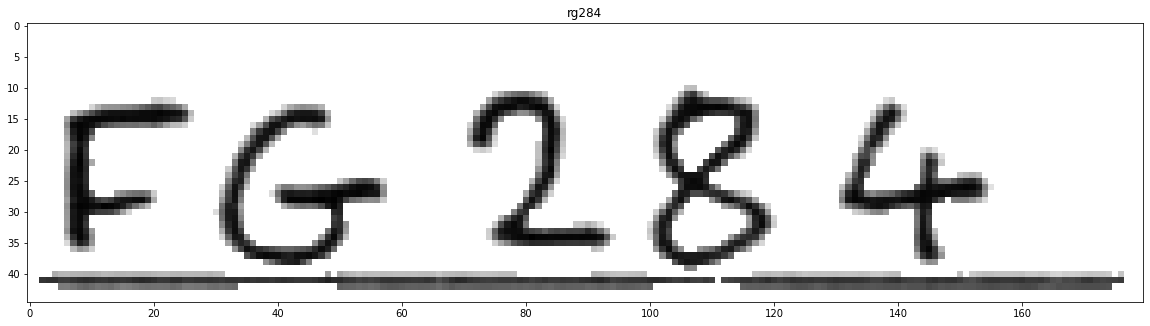

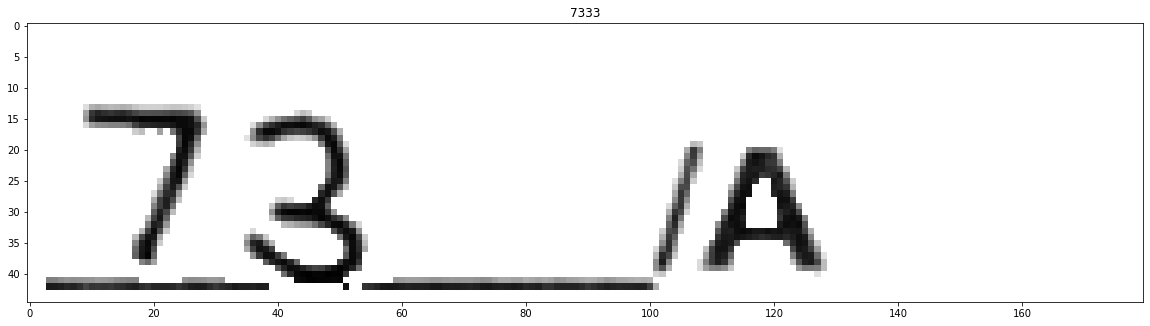

<Figure size 1440x720 with 0 Axes>

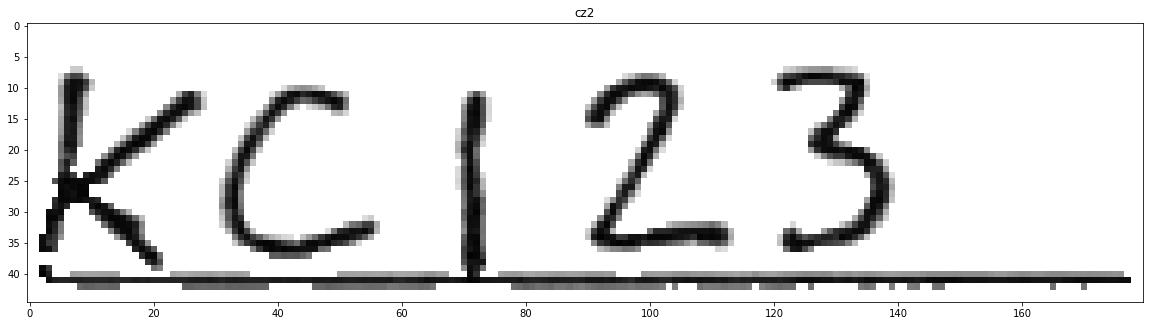

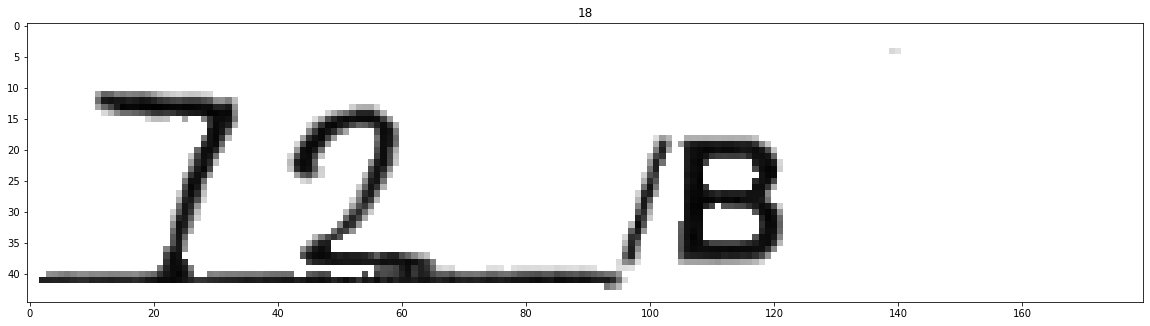

<Figure size 1440x720 with 0 Axes>

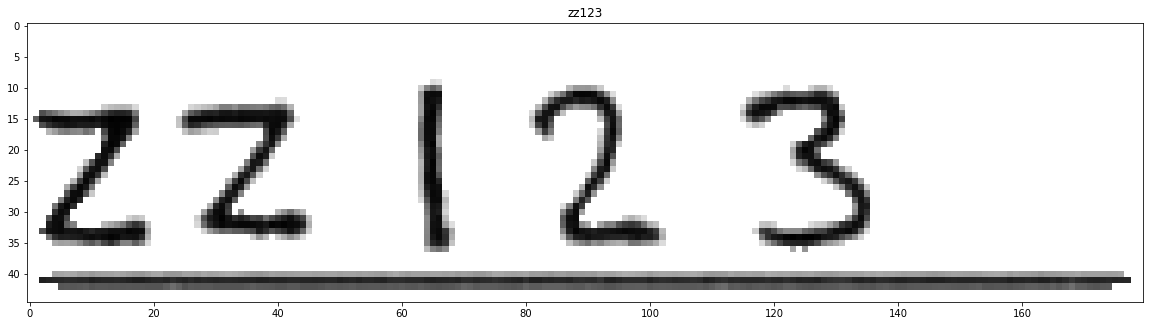

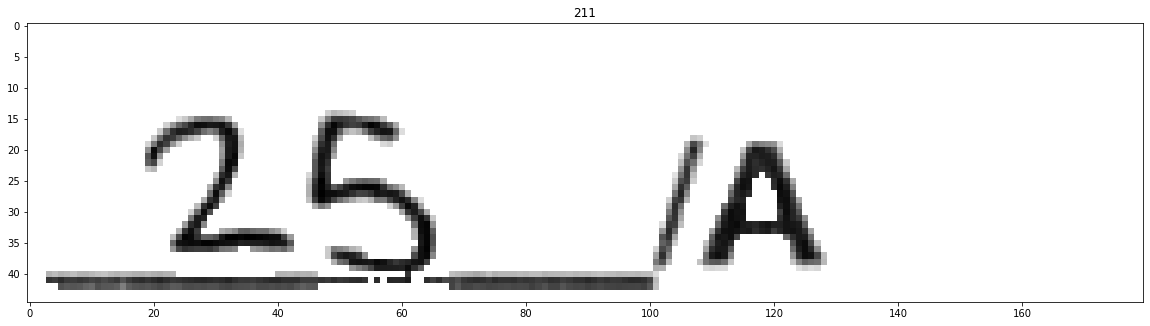

<Figure size 1440x720 with 0 Axes>

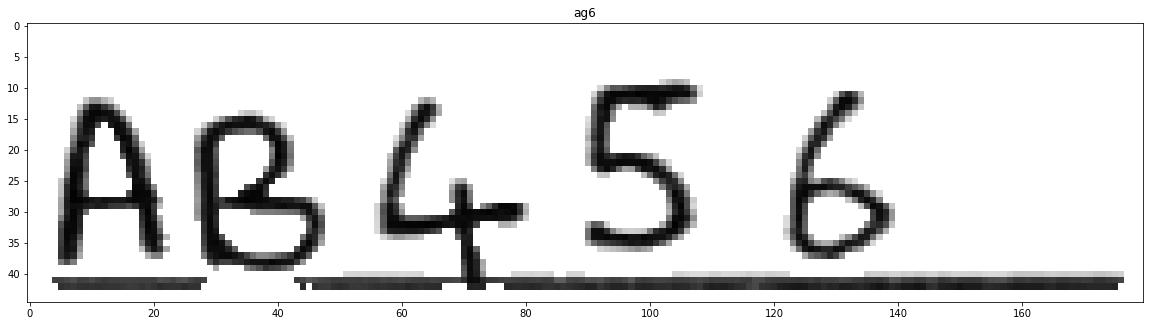

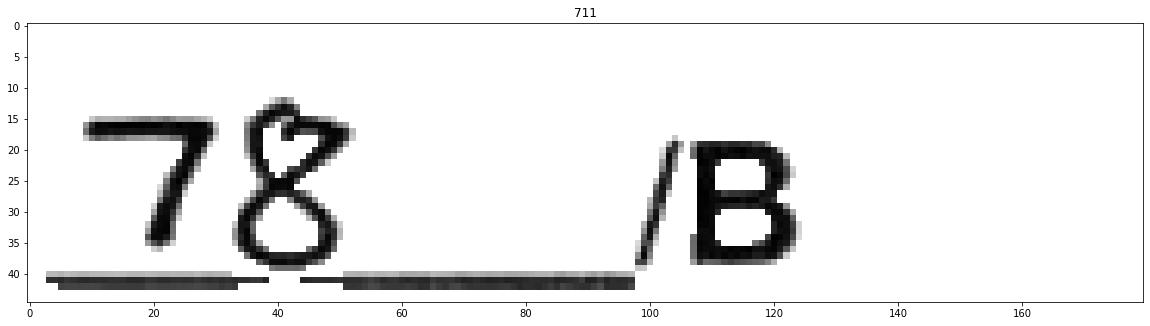

<Figure size 1440x720 with 0 Axes>

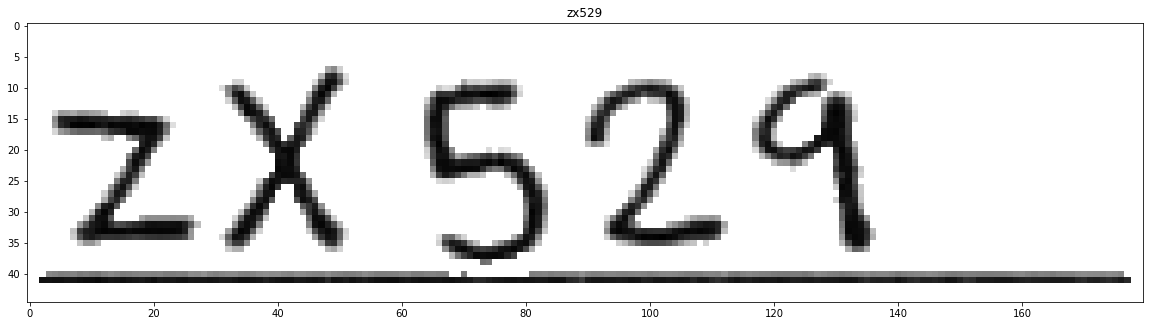

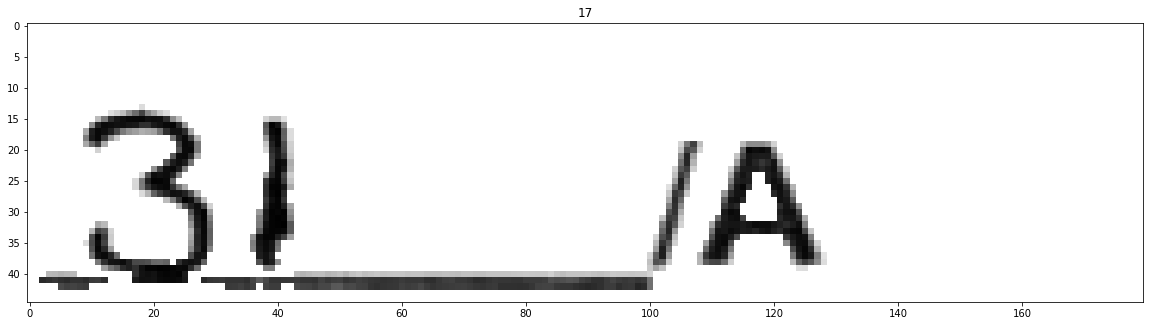

<Figure size 1440x720 with 0 Axes>

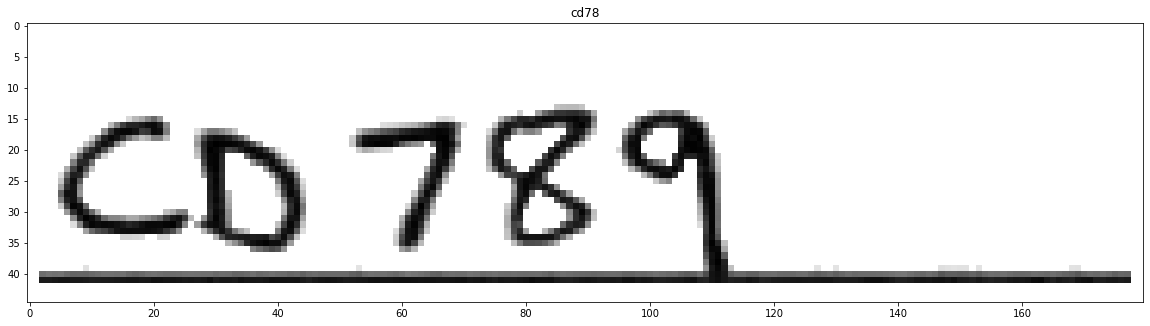

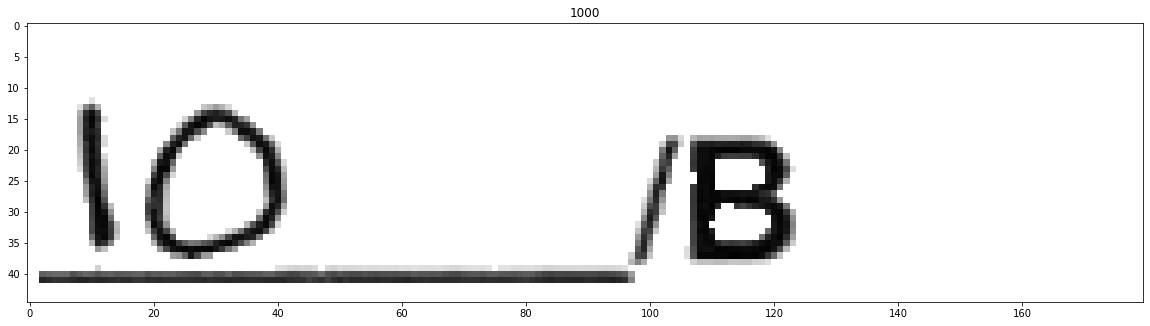

In [85]:
input_path = "C:\\GitHub\\mf724-ocr\\ETL Documents\\"
images = os.listdir(input_path)

for image in images:
    image_path = input_path + image
    scan_img = cv2.imread(image_path)
    scan_img = imutils.resize(scan_img, height=1080, width=1920)
    ocr_images = get_ocr_locs(scan_img)
    for i, ocr_image in enumerate(ocr_images):
        ocr_image = denoise(ocr_image)
        chars, _ = get_contours(ocr_image)
        #print("char length", len(chars))
        string = ""
        for j, char in enumerate(chars):
            #plt.figure()
            #plt.imshow(char.squeeze(), cmap="gray")
            pred = model.predict(char.reshape(1, 32, 32, 1))            
            if i == 0 and j <= 1:
                pred_label = decode_pred(pred, "letter")
            elif i == 0 and j >=2:
                pred_label = decode_pred(pred, "num")            
            elif i == 1 and j <= 1:
                pred_label = decode_pred(pred, "num")                
            elif i == 1 and j == len(chars):
                pred_label = decode_pred(pred, "letter")
            try:
                string = string + pred_label
            except:
                pass
        print("pred", string)
        plt.figure()
        plt.title(string)
        plt.imshow(ocr_image, cmap="gray")